# Handwritten digit classification using autoencoders

- Autoencoders are a neural network architecture. They have same input and output shape and have a symmetric shape, with the vectors shrinking to form a small vector in the middle, which is called the "encoded vector", which is then expanded by a "decoder" network to get an output with the same shape as the input.

- They can be used to learn compressed encodings of data in an **unsupervised** environment (no need of labelled data). This is why they are called autoencoders. This training can be done by giving it some input and training it to retreive the same input from the encoded vector.

- They are used for 

1. Denoising
2. In generative networks
3. For transfer learning
and many more

Source of code : https://github.com/iitkliv/dlvcnptel/blob/master/lecture12.ipynb

---

## Importing libraries and dataset

In [1]:

%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm

print(torch.__version__)

AttributeError: module 'matplotlib' has no attribute 'interactive'

## Defining basic functions needed

In [2]:
# Converting images to tensors
transform = transforms.Compose([transforms.ToTensor()])
batchsize = 20000

# Loading training and test sets
TrainSet    = datasets.MNIST(root="../downloads/MNIST", train=True, download=True, transform=transform)
TrainLoader = torch.utils.data.DataLoader(TrainSet, batch_size=batchsize, shuffle=True, num_workers=0)
TestSet     = datasets.MNIST(root="../downloads/MNIST", train=False, download=True, transform=transform)
TestLoader  = torch.utils.data.DataLoader(TrainSet, batch_size=batchsize, shuffle=True, num_workers=0)

classes    = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

In [3]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available!")
    device = "cuda"
else:
    print("GPU is not available")
    device = "cpu"

GPU is available!


## Defining the autoencoder

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 100), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(100, 28*28), nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x
    
net = autoencoder()
print(net)

net = net.double().to(device)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


## Loading pre-trained model

In [5]:
# Uncomment following lines to lead pre-trained moedls in the models directory.
#net = torch.load("./models/autoencoder.pth")
#classifier_net = torch.load("./models/autoencoder_classifier.pth")

## Defining optimizer

In [6]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=10, momentum=0.5)

## Training the autoencoder

In [7]:
iterations = 50

# Set this to true to view the input, noised input, and output of the autoencoder for each epoch
debug = False

sparcity = 0

for epoch in tqdm(range(iterations)):
    runningLoss = 0
    for i, data in enumerate(TrainLoader):
        inputs, labels = data
        inputs = inputs.double().view(-1,28*28).to(device)

        # Resetting gradients from previous run
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Computing loss (Mean Square Error + L1 penality to force sparcity)
        loss = criterion(outputs, inputs)
        loss += sparcity * torch.norm(net.encoder[0].weight, p=1)

        # Backpropagate the loss
        loss.backward()

        # Stockastic gradient descent
        optimizer.step()
        
        runningLoss += int(loss.item())

        # Display input and output of autoencoder for debugging (only for the first image for each epoch)
        if(debug and i == 0):
            plt.subplot(121)
            plt.imshow(inputs[0].view(28,28).cpu())
            plt.title("Input to autoencoder")

            plt.subplot(122)
            plt.imshow(outputs[0].view(28,28).cpu().detach())
            plt.title("Output of autoencoder")

            plt.show()

            print("Loss : %f"%(runningLoss/batchsize))

    if(epoch % 10 == 9):        
        print(" Iteration %3d/%3d, loss was %f"%(epoch+1, iterations, runningLoss))

print("Finished training")

100%|██████████| 50/50 [03:24<00:00,  4.09s/it] Iteration  50/ 50, loss was 0.000000
Finished training



## Visualising result

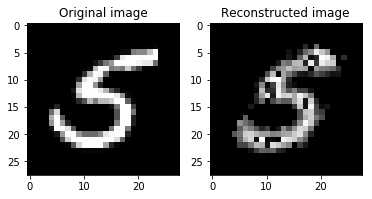

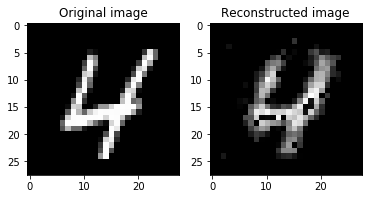

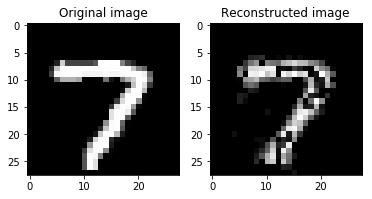

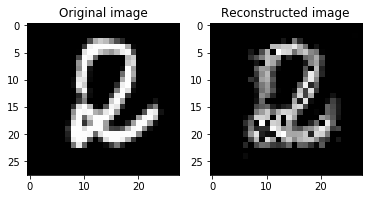

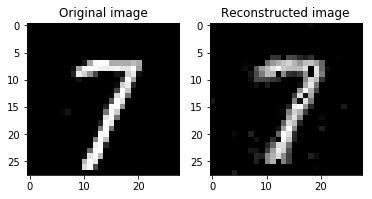

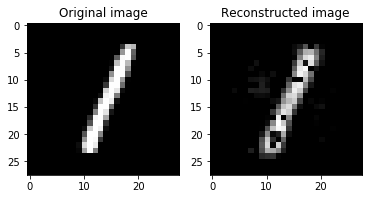

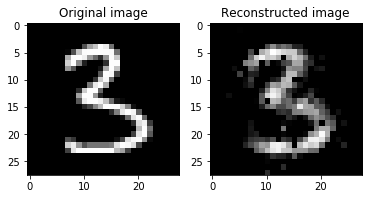

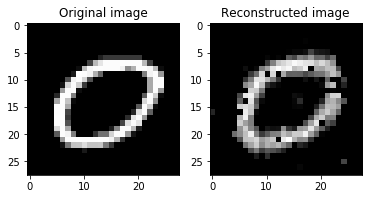

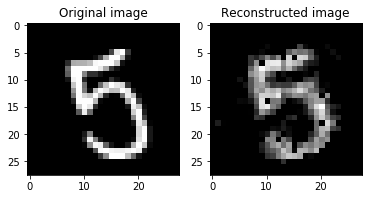

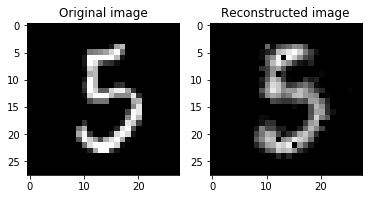

In [8]:
TestImages, _ = list(TrainLoader)[0]
indices = np.random.uniform(0, TestImages.shape[0], size=10)

for i in indices:
    print()
    
    test_img = TestImages[int(i)]

    test_noise = 100

    out = net((test_img.double().to(device).view(28*28)))
    output_img = (out.data*255).byte()
    output_img = output_img.view(-1, 28, 28)

    if device == "cuda":
        output_img = output_img.cpu()

    test_img = test_img.view(-1, 28, 28)

    plt.subplot(1,2,1)
    img = np.array(test_img.numpy())[0]
    plt.title("Original image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,2,2)
    out_img = np.array(output_img.numpy())[0]
    plt.title("Reconstructed image")
    plt.imshow(out_img, cmap="gray")

    plt.show()

## Encoder weights visualisation

In [9]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

Text(0.5,1,'Updation of weights')

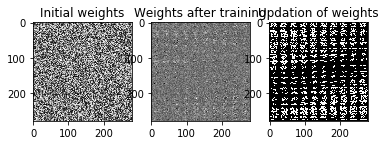

In [10]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

if use_gpu:
    init_weights = init_weights.view(-1, 280, 280).byte().cpu()
    trained_weights = trained_weights.view(-1, 280, 280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1, 280, 280).byte()

d_weights = init_weights - trained_weights

plt.subplot(131)
plt.imshow(init_weights.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights.numpy()[0], cmap="gray")
plt.title("Updation of weights")

## Adding classification layer

In [11]:
classifier = nn.Sequential()
classifier_net = classifier
classifier_net.add_module("encoder_copy", list(net.children())[0])
classifier_net.add_module("classifier", nn.Sequential(nn.Linear(100,10), nn.LogSoftmax(dim=1)))

# Locking the encoder layer (its values will not be changed during training)
lock = False
for i in list(classifier_net.children())[0][0].parameters():
    i.requires_grad = not lock

classifier_net.double().to(device)

init_weights_2 = copy.deepcopy(classifier_net[0][0].weight.data)

## Defining optimizer again

In [12]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(classifier_net.parameters(), lr=0.1, momentum=0.9)

## Training the clasifier

In [13]:
iterations = 120

for epoch in tqdm(range(iterations)):
    runningLoss = 0
    for i, data in enumerate(TrainLoader):
        inputs, labels = data
        inputs = inputs.double().to(device).view(-1,28*28)

        optimizer.zero_grad()
        outputs = classifier_net(inputs)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        
        runningLoss += int(loss.item())

    if(epoch % 10 == 9):        
        print(" Iteration %3d/%3d, loss was %f"%(epoch+1, iterations, runningLoss))

print("Finished training")

100%|██████████| 120/120 [07:33<00:00,  3.78s/it] Iteration 120/120, loss was 0.000000
Finished training



## Encoder weights visualisation (again)

In [14]:
trained_weights_2 = copy.deepcopy(classifier_net[0][0].weight.data)

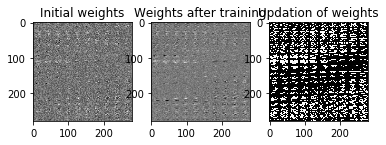

In [15]:
init_weights_2 = (1 + init_weights_2)*127.5
trained_weights_2 = (1 + trained_weights_2)*127.5

if use_gpu:
    init_weights_2 = init_weights_2.view(-1, 280, 280).byte().cpu()
    trained_weights_2 = trained_weights_2.view(-1, 280, 280).byte().cpu()
else:
    init_weights_2 = init_weights_2.view(-1,280,280).byte()
    trained_weights_2 = trained_weights_2.view(-1, 280, 280).byte()

d_weights_2 = init_weights_2 - trained_weights_2

plt.subplot(131)
plt.imshow(init_weights_2.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights_2.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights_2.numpy()[0], cmap="gray")
plt.title("Updation of weights")

plt.show()

## Output visualisation

Test set index no : 15459


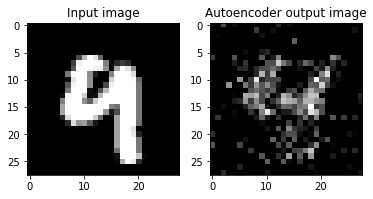

 Output of classifier : 9 
 Label : 9 

Test set index no : 11947


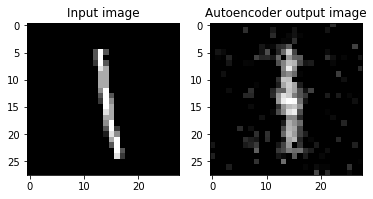

 Output of classifier : 1 
 Label : 1 

Test set index no : 7420


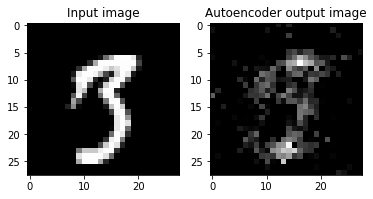

 Output of classifier : 9 
 Label : 3 

Test set index no : 15413


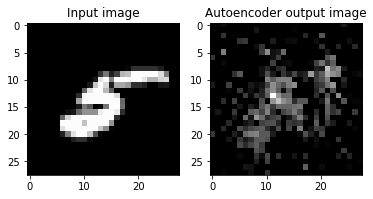

 Output of classifier : 5 
 Label : 5 

Test set index no : 18643


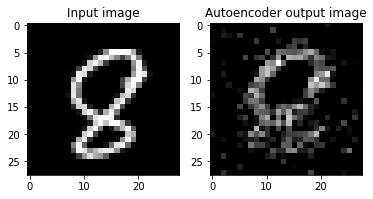

 Output of classifier : 8 
 Label : 8 

Test set index no : 19208


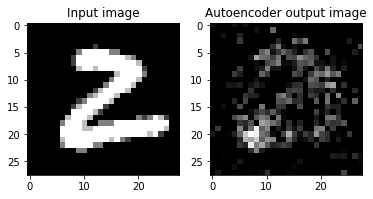

 Output of classifier : 2 
 Label : 2 

Test set index no : 15769


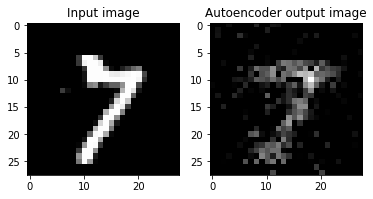

 Output of classifier : 7 
 Label : 7 

Test set index no : 16136


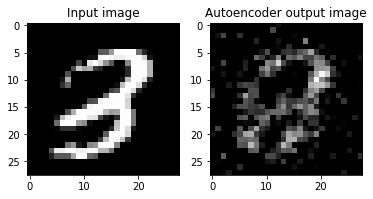

 Output of classifier : 3 
 Label : 3 

Test set index no : 7144


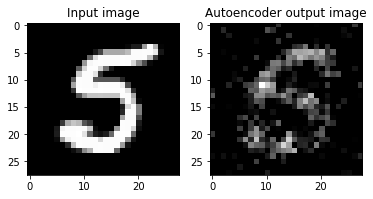

 Output of classifier : 5 
 Label : 5 

Test set index no : 19877


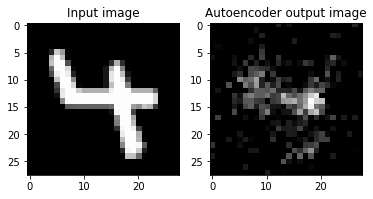

 Output of classifier : 4 
 Label : 4 



In [16]:
TestImages, TestLabels = list(TestLoader)[0]
indices = np.random.uniform(0,TestImages.shape[0],size=10)

for index in indices:
    index = int(index)

    print("Test set index no : %d"%index)

    test_img = TestImages[index]
    label = TestLabels[index]

    output = classifier_net((test_img.double().to(device)).view(1,28*28))
    output_img = net((test_img.double().to(device)).view(1,28*28)).data
    output_img = output_img
    output_img = output_img.view(-1, 28, 28)

    if device == "cuda":
        output = output.cpu()
        output_img = output_img.cpu()

    test_img = test_img.view(-1, 28, 28)

    plt.subplot(1,2,1)
    img = np.array(test_img.numpy())[0]
    plt.title("Input image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,2,2)
    img = np.array(output_img.numpy())[0]
    plt.title("Autoencoder output image")
    plt.imshow(img, cmap="gray")
    plt.show()
    
    print(" Output of classifier : %d "%np.argmax(output.detach().numpy()))
    print(" Label : %d "%label)
    print()

## Test set performance

 Basic statistics :

  zero - tests :  980, Accuracy : 98.67 %
   one - tests : 1135, Accuracy : 98.33 %
   two - tests : 1032, Accuracy : 96.12 %
 three - tests : 1010, Accuracy : 96.63 %
  four - tests :  982, Accuracy : 96.84 %
  five - tests :  892, Accuracy : 95.07 %
   six - tests :  958, Accuracy : 96.66 %
 seven - tests : 1028, Accuracy : 96.21 %
 eight - tests :  974, Accuracy : 95.17 %
  nine - tests : 1009, Accuracy : 94.55 %



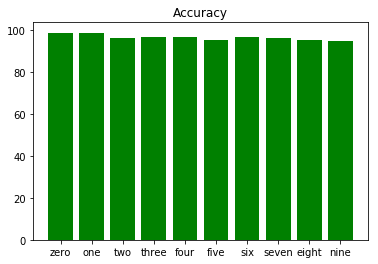


confusion matrix

Lab\Out|  zero |   one |   two | three |  four |  five |   six | seven | eight |  nine 
-------------------------------------------------------------------------------------
  zero | 98.67 |  0.00 |  0.00 |  0.20 |  0.00 |  0.41 |  0.51 |  0.10 |  0.10 |  0.00 
   one |  0.00 | 98.33 |  0.18 |  0.09 |  0.00 |  0.09 |  0.44 |  0.18 |  0.70 |  0.00 
   two |  0.48 |  0.29 | 96.12 |  0.58 |  0.48 |  0.10 |  0.48 |  0.78 |  0.68 |  0.00 
 three |  0.10 |  0.00 |  0.40 | 96.63 |  0.00 |  0.89 |  0.10 |  0.99 |  0.59 |  0.30 
  four |  0.10 |  0.00 |  0.61 |  0.00 | 96.84 |  0.10 |  0.31 |  0.20 |  0.20 |  1.63 
  five |  1.01 |  0.11 |  0.00 |  1.12 |  0.22 | 95.07 |  1.01 |  0.11 |  0.90 |  0.45 
   six |  0.84 |  0.31 |  0.21 |  0.00 |  0.63 |  0.84 | 96.66 |  0.00 |  0.52 |  0.00 
 seven |  0.10 |  0.78 |  1.26 |  0.29 |  0.29 |  0.10 |  0.00 | 96.21 |  0.10 |  0.88 
 eight |  0.41 |  0.10 |  0.21 |  0.82 |  0.41 |  0.82 |  0.92 |  0.82 | 95.17 |  0.31 
  nine |  0.89 

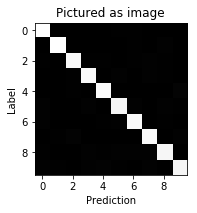

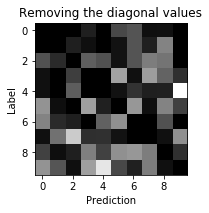

In [17]:
confusion_mat = np.zeros((10,11)).astype(np.int)

for data in TestSet:
    input, label = data

    output = classifier_net(input.to(device).double().view(-1,28*28))

    confusion_mat[label][10] += 1

    confusion_mat[label][np.argmax(output.cpu().detach())] += 1

print(" Basic statistics :")
print()
for i in range(10):
    print(" %5s - tests : %4d, Accuracy : %4.2f %%"%(classes[i], confusion_mat[i,-1], 100*confusion_mat[i,i]/confusion_mat[i,-1]))

print()

plt.title("Accuracy")
plt.bar(classes, 100*np.diag(confusion_mat)/confusion_mat[:,-1], color='g')
plt.show()

print()
print("confusion matrix")
print()

print("Lab\Out", end='')

for i in range(10):
    print("| %5s "%classes[i], end='')
print()

for i in range(85):
    print('-', end='')
print()

for i in range(10):
    print("%6ls "%classes[i], end='')
    for j in range(10):
        print("| %5.2f "%(100*confusion_mat[i][j]/confusion_mat[i][10]), end='')
    print()

for i in range(85):
    print('-', end='')
print()

plt.subplot(1,2,1)
plt.title("Pictured as image")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.imshow(confusion_mat[:,:-1]/confusion_mat[:,-1], cmap="gray")
plt.show()

plt.subplot(1,2,2)
plt.title("Removing the diagonal values")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.imshow((confusion_mat[:,:-1]/confusion_mat[:,-1])*(np.ones((10,10))-np.eye(10)), cmap="gray")
plt.show()

## What if?!

While training the classifier, the encoder layer was also trained. This is why the autoencoder output is more noisier than before. This can be solved by 

1. Copying the encoder layer using copy.deepcopy() for creating the classifier
2. Freeezing the encoder layer  while training the classifier
3. Freezing the encoder layer and train the autoencoder again (this time, only decoder layer will be trained) to improve reconstruction

However, both of these are unnecessary since the reconstructed autoencoder output is not used in our use case (recognising digits).

Just for curiosity, run this block to lock the encoder layer and run the auotencoder training code again to improve reconstructon without affecting classification performance. Not freezing the encoder layer will mess up the classification performance, since the classification layer was optimized for the other version of the encoder. While forming the classification layer, there is some code that can lock or unlock the encoder layer for the same purpose.

In [18]:
# Setting the requires_grad option in a layer enables training that layer using gradient descent. 
list(list(net.children())[0][0].parameters())[0].requires_grad = True

Check this [link](https://pytorch.org/docs/stable/notes/autograd.html) to see how requires_grad freezes layers and how automatic differentiation works in pytorch.

## Saving the model

In [19]:
torch.save(net, "./models/autoencoder.pth")
torch.save(classifier_net, "./models/autoencoder_classifier.pth")

/home/ashwin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
